# ADA Project - DataBrewers

The aim of this project is to analyze beer preference shifts across seasons and events, with a focus on understanding consumer trends in taste, aroma, palate, and appearance. By examining variation in ratings for beer style and alcohol content among US users, and comparing different states with varying weather conditions, we seek to identify seasonal trends. To deepen our understanding, we will conduct sentiment analysis to capture the tone of reviews and references to seasons, weather, or events, and correlate these insights with ratings. Our findings will provide actionable insights for professionals (brewers, marketers, etc.) by highlighting customer preferences throughout the year. Understanding these seasonal trends enables brewers to adjust product offerings to align more closely with consumer demand. As a conclusion of to our research, we could suggest the best beer that would be the perfect match for each season/festivity, in the form of a time fresco. 


## Data preprocessing

In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd


### Loading

In [4]:
import sys
sys.path.append('src')

from data.dataloader import load_matched_beer_data, load_beer_advocate_data, load_rate_beer_data

# Load the matched beer data
ratings_merged, users_approx, users_merged, beers_merged, breweries_merged = load_matched_beer_data()

# Load the BeerAdvocate data
beers_ba, reviews_ba, users_ba, breweries_ba, ratings_ba = load_beer_advocate_data()

# Load the RateBeer data
beers_rb, reviews_rb, users_rb, breweries_rb, ratings_rb = load_rate_beer_data()

### Dataset comparaison and selection 
In this following section, we compare the two datasets : BeerAdvocate and RateBeer by looking at the number of users, beers, ratings and reviews. 

**Number of users**

In [5]:
# We prompt the number of users in each dataset
nb_users_rb = len(users_rb)
nb_users_ba = len(users_ba)

print("The RateBeer dataset have", nb_users_rb, "users.")
print("The BeerAdvocate dataset have", nb_users_ba, "users.")

The RateBeer dataset have 70174 users.
The BeerAdvocate dataset have 153704 users.


**Number of beers**

In [6]:
# We prompt the number of beers in each dataset
nb_beers_rb = len(beers_rb)
nb_beers_ba = len(beers_ba)

print("The RateBeer dataset have", nb_beers_rb, "beers.")
print("The BeerAdvocate dataset have", nb_beers_ba, "beers.")

The RateBeer dataset have 442081 beers.
The BeerAdvocate dataset have 280823 beers.


**Number of ratings**

In [7]:
# We prompt the numbers of ratings in each dataset using the nbr_ratings column of the beers dataset and summing them
nb_ratings_rb = beers_rb['nbr_ratings'].sum()
nb_ratings_ba = beers_ba['nbr_ratings'].sum()

print("The RateBeer dataset have", nb_ratings_rb, "ratings.")
print("The BeerAdvocate dataset have", nb_ratings_ba, "ratings.")

The RateBeer dataset have 7122074 ratings.
The BeerAdvocate dataset have 8393032 ratings.


**Numbers of reviews**


The reviews datasets are not in a user-friendly format: all data is stored in a single column, with each review’s information spread across 16 rows. This structure requires reshaping to extract and organize the information into distinct columns for easier analysis.

In [8]:
import sys
sys.path.append('src')

from scripts.script import format_data

reviews_ba = format_data(reviews_ba, "review_id")
reviews_rb = format_data(reviews_rb, "review_id")

In [9]:
nb_reviews_rb = len(reviews_rb)
nb_reviews_ba = len(reviews_ba)

print("The RateBeer dataset have", nb_reviews_rb, "reviews.")
print("The BeerAdvocate dataset have", nb_reviews_ba, "reviews.")

The RateBeer dataset have 7122074 reviews.
The BeerAdvocate dataset have 2589586 reviews.


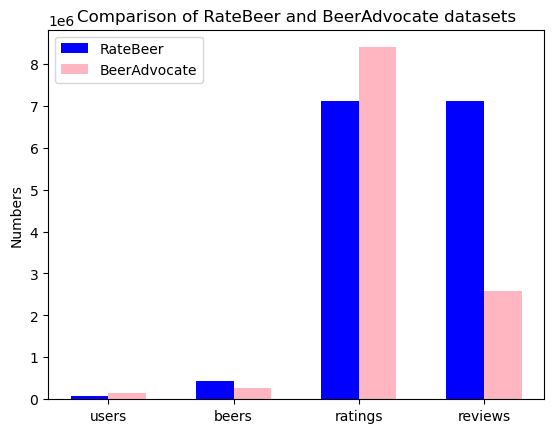

In [10]:
labels = ["users", "beers", "ratings", "reviews"]

rb_counts = [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb]
ba_counts = [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]

x = np.arange(len(labels))
width = 0.3

fig, ax = plt.subplots()
bars_rb = ax.bar(x - width/2, rb_counts, width, label='RateBeer', color='blue')
bars_ba = ax.bar(x + width/2, ba_counts, width, label='BeerAdvocate', color='lightpink')

ax.set_ylabel('Numbers')
ax.set_title('Comparison of RateBeer and BeerAdvocate datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [11]:
summary_data = {
    "Metric": ["users", "beers", "ratings", "reviews"],
    "RateBeer": [nb_users_rb, nb_beers_rb, nb_ratings_rb, nb_reviews_rb],
    "BeerAdvocate": [nb_users_ba, nb_beers_ba, nb_ratings_ba, nb_reviews_ba]
}
summary_df = pd.DataFrame(summary_data)
summary_df.style.set_caption("Summary for RateBeer and BeerAdvocate")

,Metric,RateBeer,BeerAdvocate
0,users,70174,153704
1,beers,442081,280823
2,ratings,7122074,8393032
3,reviews,7122074,2589586


The BeerAdvocate dataset provides us with enough reviews and data to perform and we will focus only on this dataset for the rest of the analysis.

1. **The Herding Effect:** As explained in the paper "When Sheep Shop: Measuring Herding Effects in Product Ratings with Natural Experiments" from Gael Lederrey and Robert West, initial ratings can influence the following ones. By focusing on a single dataset, we can better control for this effect within a single user community. Including RateBeer might introduce inconsistent herding effects that could skew comparative analyses.
2. **Inconsistant Rating Standards:** Both BeerAdvocate and RateBeer communities likely develop their own informal standards for beer ratings. Focusing on a single platform like BeerAdvocate allows dor a more cohesive dataset, with users who rate within the same context, minimizing cross-platform variance.
3. **Data Sufficiency:** The BeerAdvocate dataset provides us with enough reviews and data to perform meaningful analysis and draw reliable insights.

### Analysis of users’ countries of origin

In [12]:
# Separate the country and the states
users_ba['country'] = users_ba['location'].str.split(',').str[0]
users_ba['states'] = users_ba['location'].str.split(',').str[1]

In [13]:
missing_countries = users_ba['country'].isna().sum()
total_entries = len(users_ba)
missing_percentage = (missing_countries / total_entries) * 100

print(f"Number of missing 'country' entries: {missing_countries} ({missing_percentage:.2f}%)")

Number of missing 'country' entries: 31279 (20.35%)


In [14]:
# Replace missing 'country' values with a label "Unknown"
users_ba['country'] = users_ba['country'].fillna('Unknown')

# Compute the number of users in the top 5 countries
top5_countries = users_ba['country'].value_counts().nlargest(5)

# Compute the sum of the remaining countries (including 'Unknown' entries if any)
other_countries_count = len(users_ba) - top5_countries.sum()

# Add the "Other" countries count to the series
top_countries = pd.concat([top5_countries, pd.Series({'Other': other_countries_count})])

# Calculate percentages for each country in top_countries
top_countries_percent_ba = (top_countries / len(users_ba) * 100).round(1)

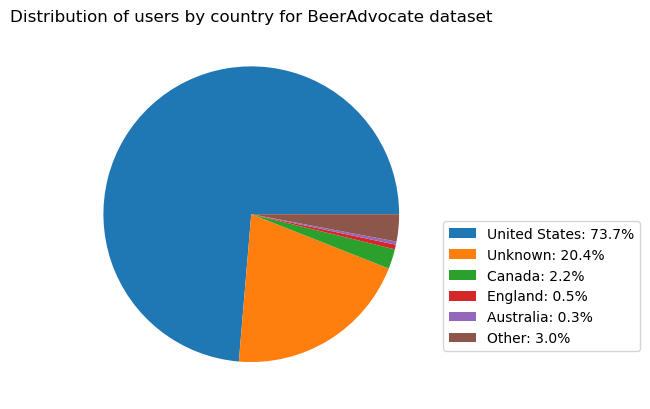

In [15]:
top_countries.plot(kind='pie', labels=None)

# Create legend with country name and percentage
top_countries_labels = [f"{country}: {percent}%" for country, percent in zip(top_countries.index, top_countries_percent_ba)]
plt.legend(labels=top_countries_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by country for BeerAdvocate dataset')
plt.show()

The majority of the users are from the United States. 

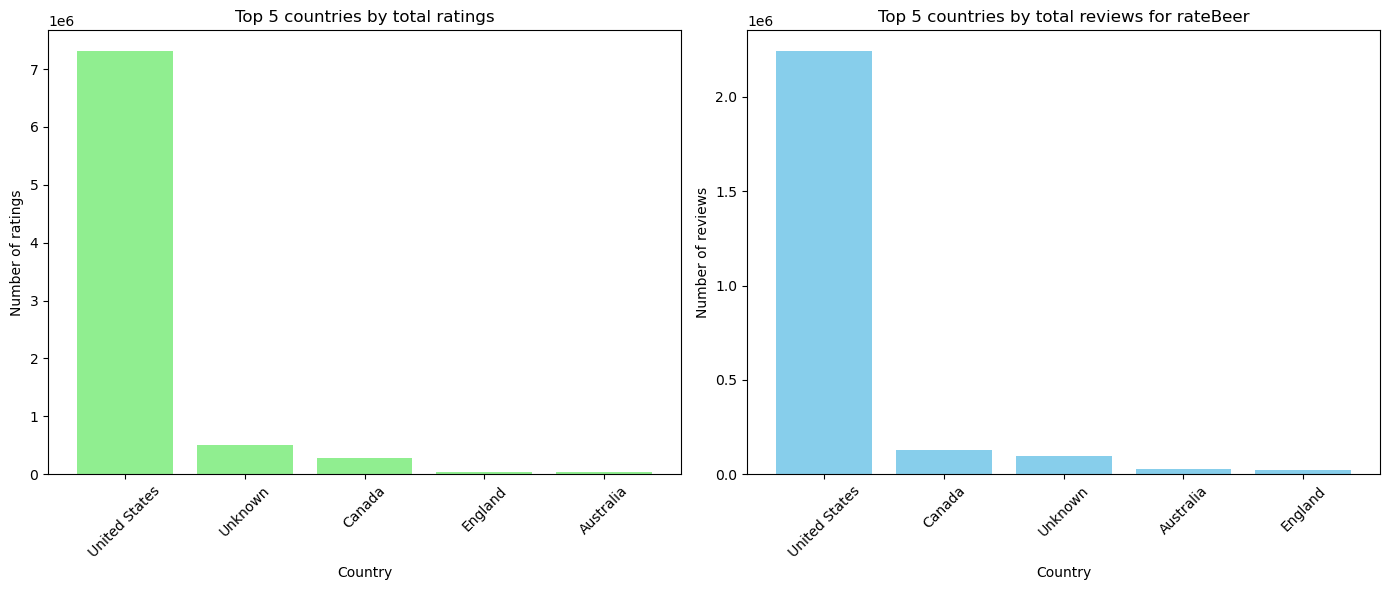

In [16]:
# Convert the number of ratings values to numeric
users_ba['nbr_ratings'] = pd.to_numeric(users_ba['nbr_ratings'], errors='coerce')
users_ba['nbr_reviews'] = pd.to_numeric(users_ba['nbr_reviews'], errors='coerce')

# Group by country and sum the ratings and the reviews
country_ratings = users_ba.groupby('country')['nbr_ratings'].sum().reset_index()
country_reviews = users_ba.groupby('country')['nbr_reviews'].sum().reset_index()

# Get the top 5 countries by number of ratings and reviews
top_countries_ratings = country_ratings.nlargest(5, 'nbr_ratings')
top_countries_reviews = country_reviews.nlargest(5, 'nbr_reviews')


fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].bar(top_countries_ratings['country'], top_countries_ratings['nbr_ratings'], color='lightgreen')
axes[0].set_xlabel('Country')
axes[0].set_ylabel('Number of ratings')
axes[0].set_title('Top 5 countries by total ratings')
axes[0].tick_params(axis='x', rotation=45)

axes[1].bar(top_countries_reviews['country'], top_countries_reviews['nbr_reviews'], color='skyblue')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Number of reviews')
axes[1].set_title('Top 5 countries by total reviews for rateBeer')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Most of the ratings and reviews are made by american users. 


Therefore, we have chosen to focus on the reviews and ratings published by users based in the United State of America. The reason for this choice is that it is the country where the majority of reviews and ratings are done, and it provides us with enough data to conduct our analysis.



In [17]:
# Keep only users from the US
users = users_ba[users_ba['country'] == 'United States']
print("There are", len(users), "users from the United States in the BeerAdvocate dataset")

# Prompt the number of ratings made by US users using the nb_ratings column of the users dataset and summing them for users where location contains United States 
print("Number of ratings made by US users: ", users[users['country'].str.contains('United States')]['nbr_ratings'].sum())

# Prompt the number of reviews made by US users using the nb_reviews column of the users dataset and summing them for users where location contains United States
print("Number of reviews made by US users: ", users[users['country'].str.contains('United States')]['nbr_reviews'].sum())

There are 113223 users from the United States in the BeerAdvocate dataset
Number of ratings made by US users:  7303870
Number of reviews made by US users:  2241334


In [18]:
# Merge the reviews with user information on location
reviews_ba = reviews_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

In [19]:
# Remove the states to only have the countries
reviews_ba['country'] = reviews_ba['location'].str.split(',').str[0]

# Remove the countries to only have the states
reviews_ba['states'] = reviews_ba['location'].str.split(',').str[1]

# We only keep users from the US
reviews = reviews_ba[reviews_ba['country'] == 'United States']

The reviews dataset contains now the country of origin of the users. 


The ratings datasets are not in a user-friendly format: all data is stored in a single column, with each rating’s information spread across 16 rows. As for the review dataset, it requires reshaping to extract and organize the information into distinct columns for easier analysis. Moreover, as we are only focusing on american users, it also requires filtering based on the location of the user.

In [20]:
# Reshape the ratings dataset
ratings_ba = format_data(ratings_ba, "rating_id")

In [21]:
# Merge the reviews with user information on location
ratings_ba = ratings_ba.merge(users_ba[['user_id', 'location']], on='user_id', how='left')

# Remove the states to only have the countries
ratings_ba['country'] = ratings_ba['location'].str.split(',').str[0]

# Remove the countries to only have the states
ratings_ba['states'] = ratings_ba['location'].str.split(',').str[1]

# We only keep users from the US
ratings = ratings_ba[ratings_ba['country'] == 'United States']

### Data storing 

**Saving the data on local**

In [22]:
reviews.to_csv('data/reviews_processed.csv.gz', index=False, compression='gzip')
ratings.to_csv('data/ratings_processed.csv.gz', index=False, compression='gzip')
users.to_csv('data/users_processed.csv.gz', index=False, compression='gzip')
beers_ba.to_csv('data/beers_ba_processed.csv.gz', index=False, compression='gzip')
breweries_ba.to_csv('data/breweries_ba_processed.csv.gz', index=False, compression='gzip')

**Load the data from local**

In [2]:
reviews = pd.read_csv('data/reviews_processed.csv.gz', compression='gzip')
ratings = pd.read_csv('data/ratings_processed.csv.gz', compression='gzip')
users = pd.read_csv('data/users_processed.csv.gz', compression='gzip')
beers_ba = pd.read_csv('data/beers_ba_processed.csv.gz', compression='gzip')
breweries_ba = pd.read_csv('data/breweries_ba_processed.csv.gz', compression='gzip')

### Analysis of users' states of origin 

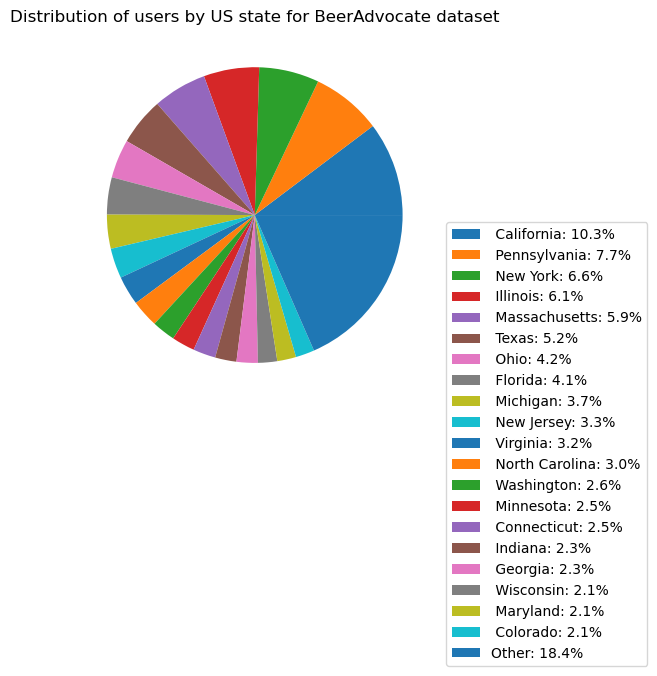

In [3]:
# Compute the number of users in the top 20 states
top20_states = users['states'].value_counts().nlargest(20)

# Compute the sum of the remaining states
other_users_count = len(users) - top20_states.sum()

# Add the "Other" states count to the series
top_states = pd.concat([top20_states, pd.Series({'Other': other_users_count})])

# Calculate percentages for each country in top_countries
top_states_percent = (top_states / len(users) * 100).round(1)

top_states.plot(kind='pie', labels=None)

# Create legend with state name and percentage
top_states_labels = [f"{state}: {percent}%" for state, percent in zip(top_states.index, top_states_percent)]
plt.legend(labels=top_states_labels, loc="best", bbox_to_anchor=(1, 0.5))

plt.title(f'Distribution of users by US state for BeerAdvocate dataset')
plt.show()

There is considerable diversity in the origins of U.S. users, with 10.3% from California, a generally warmer region, and 7.7% and 6.6% from Pennsylvania and New York, respectively, where colder climates are common.
We decided to regroup the state into 4 categories based on geographical regions in the United States:
- South: Texas, Georgia, Florida, ...
- West: California, Colorado, Washington, ...
- Northeast: New York, New Jersey, Pennsylvania, ...
- Midwest: Illinois, Michigan, Ohio, ... 

In [5]:
regions = {
    'Northeast': ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 
                  'Vermont', 'New Jersey', 'New York', 'Pennsylvania'],
    'Midwest': ['Illinois', 'Indiana', 'Iowa', 'Kansas', 'Michigan', 'Minnesota', 'Missouri', 
                'Nebraska', 'North Dakota', 'Ohio', 'South Dakota', 'Wisconsin'],
    'South': ['Alabama', 'Arkansas', 'Delaware', 'Florida', 'Georgia', 'Kentucky', 'Louisiana', 
              'Maryland', 'Mississippi', 'North Carolina', 'Oklahoma', 'South Carolina', 
              'Tennessee', 'Texas', 'Virginia', 'West Virginia'],
    'West': ['Alaska', 'Arizona', 'California', 'Colorado', 'Hawaii', 'Idaho', 'Montana', 
             'Nevada', 'New Mexico', 'Oregon', 'Utah', 'Washington', 'Wyoming']
}

# Assign region based on state
def assign_region(state):
    # Remove spaces
    state = state.strip().title()
    
    for region, states in regions.items():
        if state in states:
            return region
    return 'Other'

users['region'] = users['states'].apply(assign_region)


In [6]:
# Count the number of users in each region
region_counts = users['region'].value_counts()
print(region_counts)

region
Northeast    32903
South        30359
Midwest      28002
West         21959
Name: count, dtype: int64


There are no users that don't have an assigned region. 

In [7]:
ratings = ratings.merge(users[['user_id', 'region']], on='user_id', how='left')
reviews = reviews.merge(users[['user_id', 'region']], on='user_id', how='left')

### Analysis of beer style

In [8]:
# List of words from 'style' column to remove
words_to_remove = ['American ', 'Double / Imperial ', 'English ', ' (APA)']

def clean_style_column(df):
    for word in words_to_remove:
        df['style'] = df['style'].str.replace(word, '', regex=False)
    return df

beers_ba = clean_style_column(beers_ba)
ratings = clean_style_column(ratings)
reviews = clean_style_column(reviews)

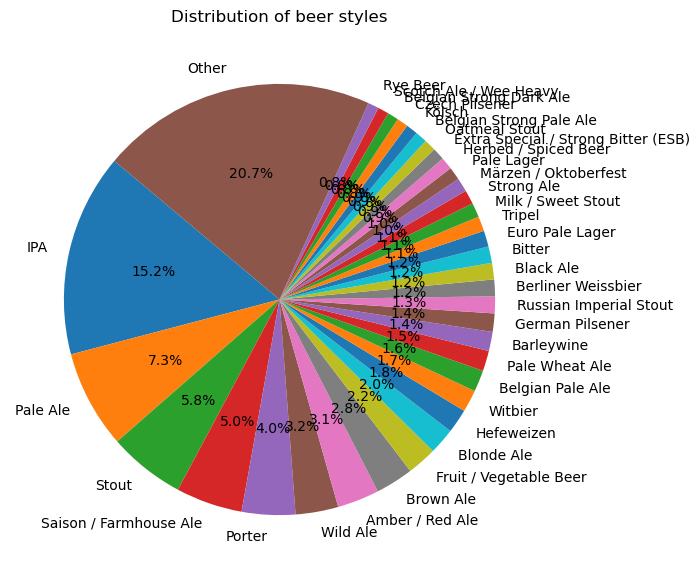

In [9]:
# Compute the number of users in the top 35 states
top35_style = beers_ba['style'].value_counts().nlargest(35)

# Compute the sum of the remaining styles
other_style_count = len(beers_ba) - top35_style.sum()

# Add the "Other" style count to the series
top_states = pd.concat([top35_style, pd.Series({'Other': other_style_count})])

plt.figure(figsize=(7, 7))
top_states.plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Distribution of beer styles')
plt.ylabel('') 
plt.show()

Most of the beer style are IPA then Pale Ale, Stout, ... 

In [10]:
# Get the number of rating for each beer_id
ratings_count = ratings['beer_id'].value_counts().rename('count')

# Join ratings count with beers_ba DataFrame to get styles and names for each beer
ratings_count = ratings_count.to_frame().join(beers_ba[['style', 'beer_name']], how='left')

total_ratings = ratings_count['count'].sum()

# Group by 'style'  to get total count for eac
style_above_2_percent = ratings_count.groupby('style')['count'].sum()
style_above_2_percent = style_above_2_percent[style_above_2_percent > (0.02 * total_ratings)]#keep only the beer style that have more than 2% of the total ratings 

In [11]:
# List of beer styles that exceed 2% of total ratings
beer_styles_above_2_percent = style_above_2_percent.index.tolist()

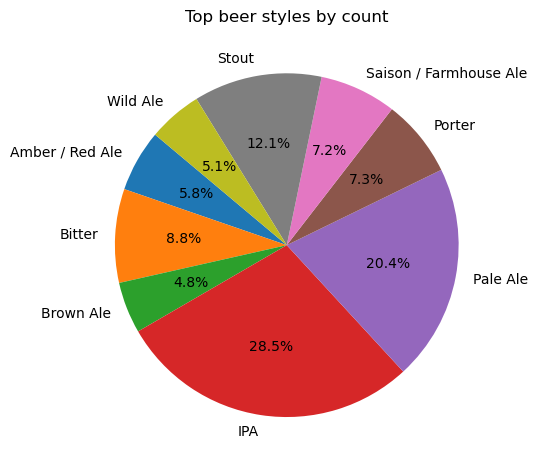

In [12]:
plt.pie(style_above_2_percent, labels=style_above_2_percent.index, autopct='%1.1f%%', startangle=140)
plt.title('Top beer styles by count')

plt.tight_layout()
plt.show()

The beer style the most rated are IPA, Pale, Ale, Porter, Russian, Imperial Stout, ...

In [13]:
# Count the number of unique beers for each style
beer_per_style = ratings_count.groupby('style')['beer_name'].nunique().nlargest(10)

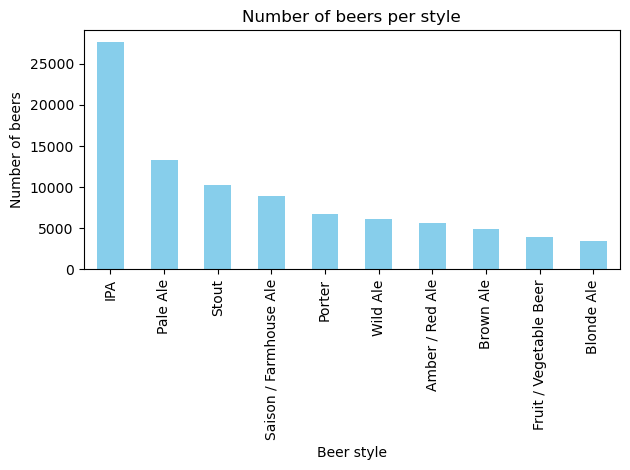

In [14]:
beer_per_style.plot(kind='bar', color='skyblue')
plt.title('Number of beers per style')

plt.xlabel('Beer style')
plt.ylabel('Number of beers')

# Adjust layout for better display
plt.tight_layout()
plt.show()

### Analysis of the beer percentage of alcohol by volume

In [15]:
reviews['abv'].describe()

count    2.181501e+06
mean     7.254056e+00
std      2.385050e+00
min      1.000000e-02
25%      5.400000e+00
50%      6.800000e+00
75%      8.700000e+00
max      6.750000e+01
Name: abv, dtype: float64

We can categorize beer types based on their Alcohol by Volume (ABV) percentage as follows:
- **low ABV**: 0-25% quantile → ABV up to 5.5%
- **medium ABV**: 25%-75% quantile → ABV between 5.5% and 8.8%
- **high ABV**: 75%-100% quantile → ABV higher than 8.8%

In [16]:
# Calculate the quantiles
abv_quantiles = reviews['abv'].quantile([0.25, 0.5, 0.75])

def categorize_abv(abv_value):
    if abv_value <= abv_quantiles[0.25]:  # Low ABV
        return 'low'
    elif abv_value <= abv_quantiles[0.75]:  # Medium ABV
        return 'middle'
    else:  # High ABV
        return 'high'

reviews['abv_category'] = reviews['abv'].apply(categorize_abv)
ratings['abv_category'] = ratings['abv'].apply(categorize_abv)

### Analysis of the publication timing of user reviews

In [17]:
# Extract the year, month, and day
reviews['date']  = pd.to_datetime(reviews['date'], unit='s', errors='coerce')
reviews['year'] = reviews['date'].dt.year
reviews['month'] = reviews['date'].dt.month
reviews['day'] = reviews['date'].dt.day

In [18]:
# Extract the year, month, and day
ratings['date']  = pd.to_datetime(ratings['date'], unit='s', errors='coerce')
ratings['year'] = ratings['date'].dt.year
ratings['month'] = ratings['date'].dt.month
ratings['day'] = ratings['date'].dt.day

In [19]:
def get_season(month):
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
    elif month in [12, 1, 2]:
        return 'Winter'

In [20]:
# Separate the reviews by seasons
reviews['season'] = reviews['month'].apply(get_season)

# Separate the ratings by seasons
ratings['season'] = ratings['month'].apply(get_season)

**Over the years**

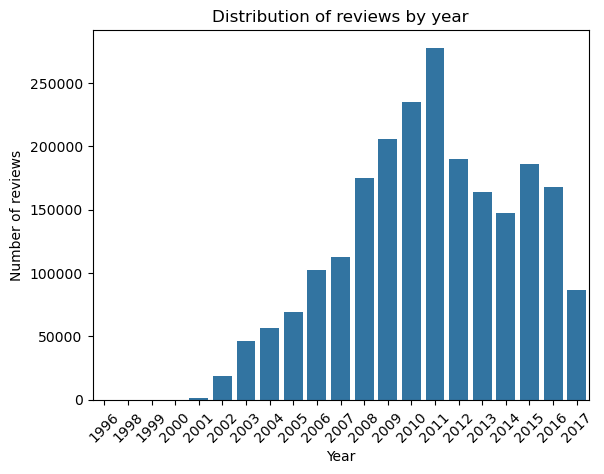

In [21]:
# Plot yearly review counts

sns.countplot(data=reviews, x='year', legend=False)
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We can see that before 2002, there are few reviews given by users on the BeerAdvocate website. We can choose a threshold of a minimum of 70'000 reviews by year to have enough reviews published by year to analyze the change over a year.

In [22]:
# Count the number of reviews by year
reviews_per_year = reviews['year'].value_counts()

# Filter to keep only years with more than 70'000 reviews
years_above_threshold = reviews_per_year[reviews_per_year > 70000].index
reviews = reviews[reviews['year'].isin(years_above_threshold)]
ratings = ratings[ratings['year'].isin(years_above_threshold)]

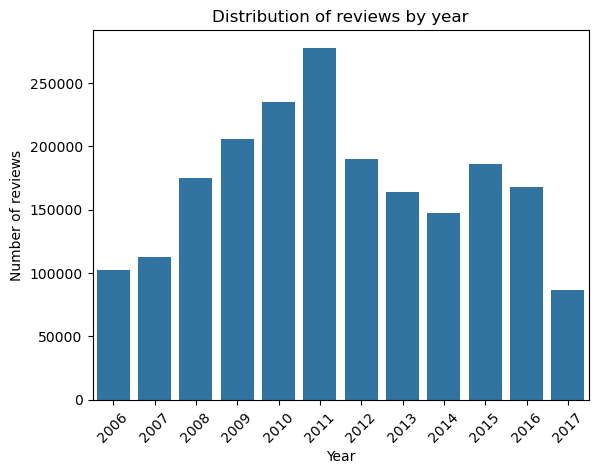

In [23]:
sns.countplot(data=reviews, x='year')
plt.title('Distribution of reviews by year')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

We now have only reviews published between 2006 and 2017

**Across the seasons**

/opt/anaconda3/envs/ada/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


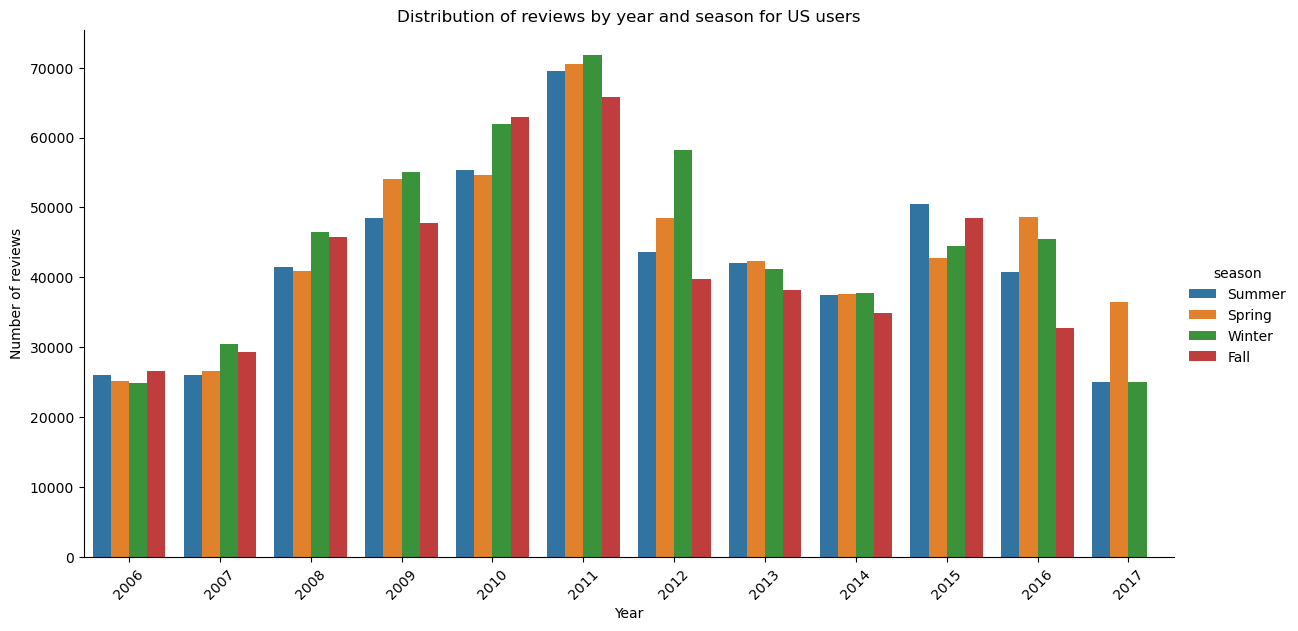

In [24]:
sns.catplot(data=reviews, x='year', hue='season', kind='count', height=6, aspect=2, legend=True)
plt.title('Distribution of reviews by year and season for US users')
plt.xlabel('Year')
plt.ylabel('Number of reviews')
plt.xticks(rotation=45)
plt.show()

Between 2006 and 2017, there is no distinct season with consistently higher review activity, except for notable peaks in Winter 2012 and Spring 2017.

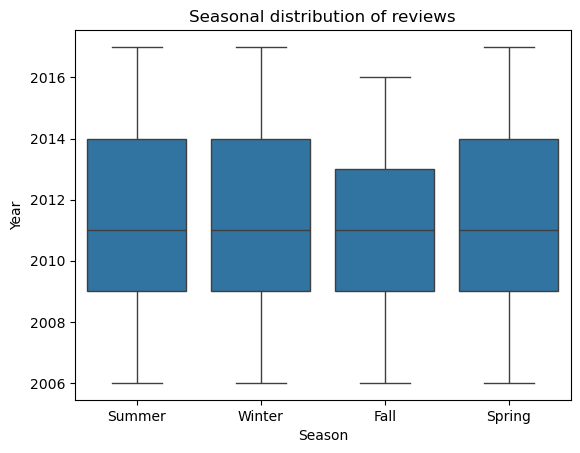

In [25]:
sns.boxplot(x='season', y='year', data=reviews)
plt.title('Seasonal distribution of reviews')
plt.xlabel('Season')
plt.ylabel('Year')
plt.show()

Each season has approximately the same number of reviews.

## Seasonal trend analysis

### For all years

In this section, we analyze the impact of style and alcohol concentration on the rating of a beer across seasons. This analysis is performed with the ratings from all years selected in the previous section.

#### By simplified styles

In this subsection, we analyze the impact of the style of the beer on its rating across seasons.

#### By alcohol concentration

In this subsection, we analyze the impact of the concentration of alcohol on a beer rating across seasons. 

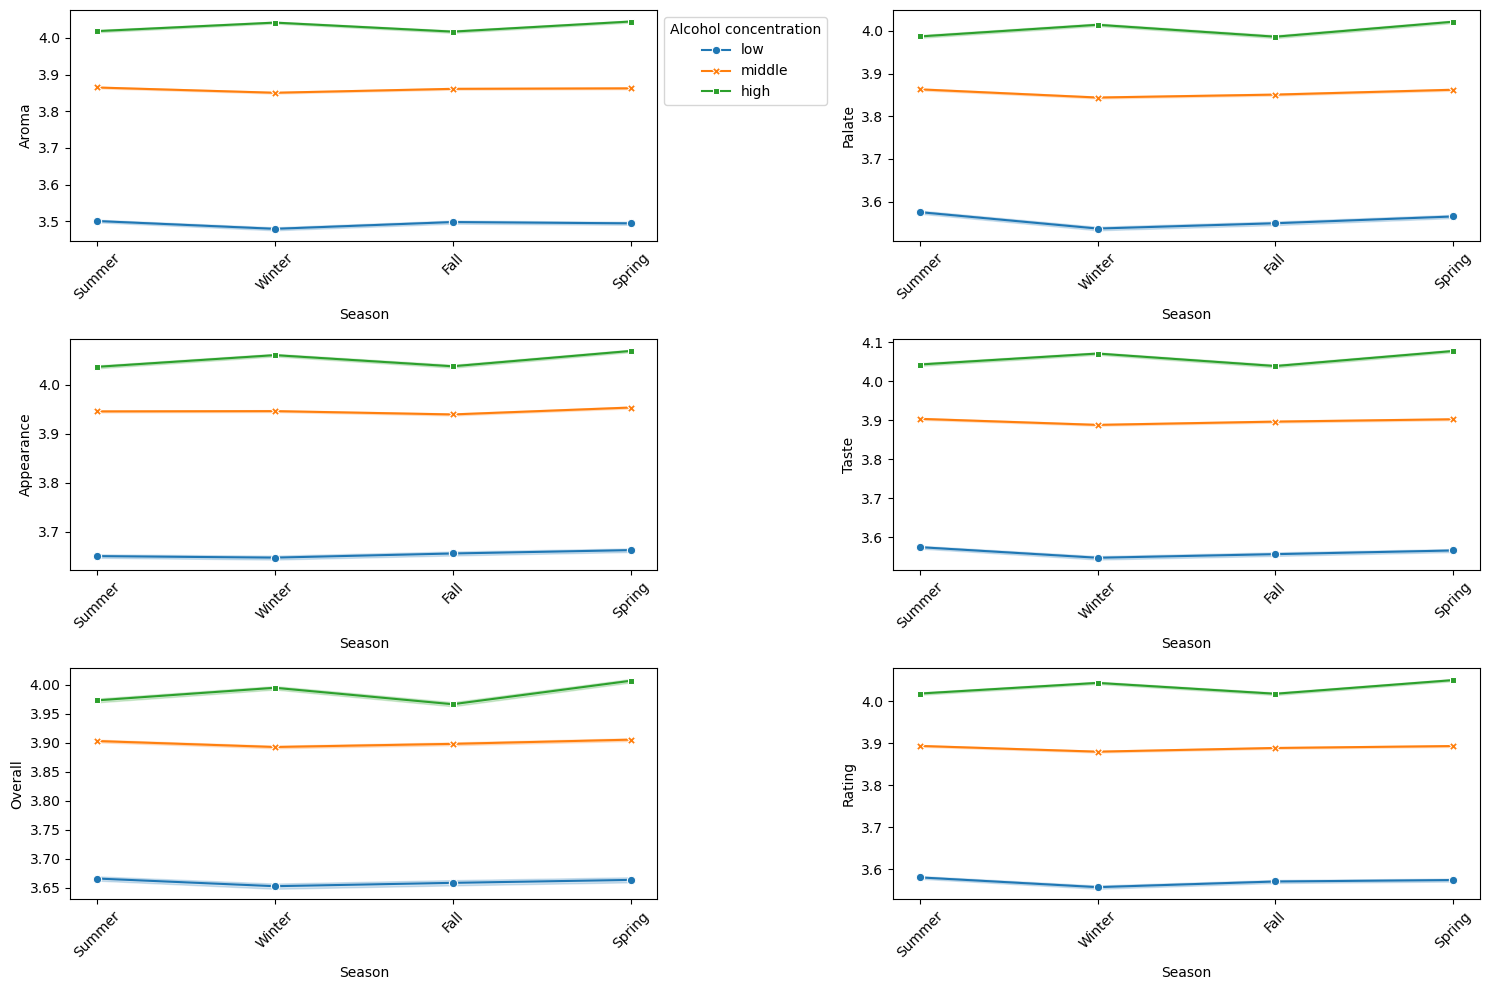

In [26]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']


plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=reviews, x='season', y=rating, hue='abv_category', style='abv_category', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    # Only display the legend in the top-left subplot (plt_index == 1)
    if plt_index == 1:
        plt.legend(title='Alcohol concentration', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

All metrics follow the same trend across seasons for each alcohol concentration category. The 'rating' metric is computed based on all other scores so we will use it to see if there is any statistical differences in between percentage of alcohol categories. Very few variation is observed in between seasons.

In [27]:
import sys
sys.path.append('src')

from scripts.script import anova_abv_test

In [28]:
anova_season_rating_abv = anova_abv_test(reviews, rating_column='rating', timescale='season') 

season: Summer, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between alcohol percentage
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  high    low  -0.4372   0.0 -0.4423 -0.4321   True
  high middle  -0.1245   0.0  -0.129   -0.12   True
   low middle   0.3127   0.0  0.3082  0.3171   True
---------------------------------------------------
--------------------------------------------------
season: Winter, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between alcohol percentage
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  high    low  -0.4858   0.0 -0.4909 -0.4806   True
  high middle  -0.1635   0.0 -0.1677 -0.1594   True
   low middle   0.3222   0.0  0.3175   0.327   True
-------------------------------------------------

There is a significant difference between ratings for all seasons in between all alcohol concentration categories. On average, the higher the alcohol percentage in a beer, the higher it is rated, independently of the seasons. 

### Year by year

#### By alcohol concentration

In this section, we analyze the impact of the concentration of alcohol on the rating of a beer across years. 

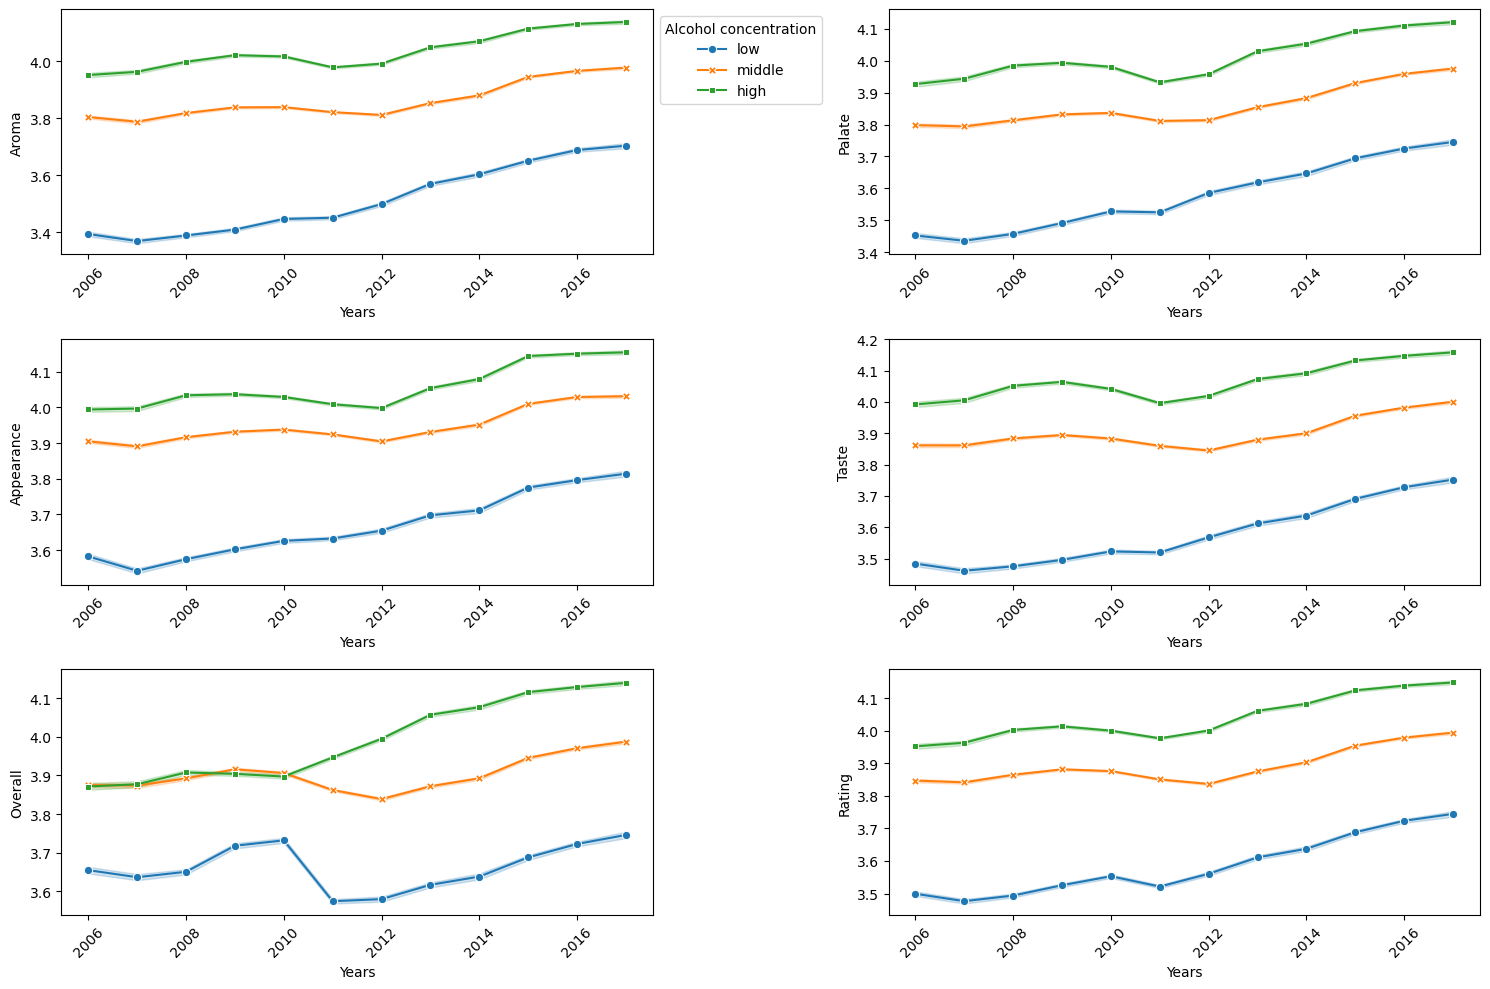

In [29]:
plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=reviews, x='year', y=rating, hue='abv_category', style='abv_category', markers=True, dashes=False)

    plt.xlabel('Years')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    # Only display the legend in the top-left subplot (plt_index == 1)
    if plt_index == 1:
        plt.legend(title='Alcohol concentration', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

Across years, all metric have the same evolution trend for all alcohol concentrations, except for the overall score which shows more variability. The overall score accounts for 20% of the rating metric, and thus we can consider this variability is represented in the rating metric. We will now only study the rating metric.

In [30]:
anova_year_rating_abv = anova_abv_test(reviews, rating_column='rating', timescale='year') 

year: 2015, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between alcohol percentage
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  high    low  -0.4354   0.0 -0.4442 -0.4267   True
  high middle  -0.1696   0.0 -0.1767 -0.1624   True
   low middle   0.2659   0.0  0.2581  0.2737   True
---------------------------------------------------
--------------------------------------------------
year: 2009, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between alcohol percentage
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj  lower   upper  reject
---------------------------------------------------
  high    low  -0.4876   0.0 -0.4956 -0.4796   True
  high middle   -0.132   0.0  -0.139  -0.125   True
   low middle   0.3557   0.0  0.3486  0.3627   True
---------------------------------------------------
-----

We observe the same phenomenon as with the seasonal ANOVA test, the higher the alcohol concentration, the higher the rating.

In [ ]:
reviews['year_season']= reviews['year'].astype(str) + ' ' + reviews['season'].astype(str) 

In [ ]:
season_order = ['Winter', 'Spring', 'Summer', 'Fall']

reviews['year_season'] = pd.Categorical(
    reviews['year_season'],
    categories=sorted(reviews['year_season'].unique(), key=lambda x: (int(x.split()[0]), season_order.index(x.split()[1]))),
    ordered=True
)

plt.figure(figsize=(16, 4))
sns.lineplot(data=reviews, x='year_season', y='rating', hue='abv_category', style='abv_category', markers=True, dashes=False)

plt.xlabel('Years')
plt.ylabel(f'{rating.capitalize()}')
plt.xticks(rotation=45)
plt.legend(title='Alcohol concentration', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

### By states

In this section, we analyze whether the users’ regions of origin influence their ratings across different seasons. The four regions (South, Midwest, Northeast, and West) experience different climate conditions. For example, winters in the Northeast are typically much colder than those in the South. These seasonal climate differences may shape user preferences and, consequently, their ratings. By examining these patterns, we aim to understand if and how seasonal variations across regions impact user ratings.

#### Comparaison by states

First, we need to ensure that the number of ratings is relatively consistent across each category:

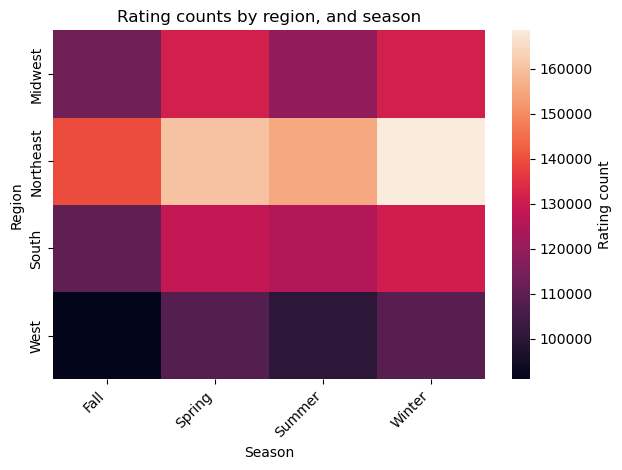

In [46]:
ratings_count = reviews.groupby(['region', 'season'])['overall'].count().reset_index()
ratings_count = ratings_count.rename(columns={'overall': 'rating_count'})

pivot_table = ratings_count.pivot_table(
    index='region', columns='season', values='rating_count', fill_value=0
)

sns.heatmap(pivot_table, cbar_kws={'label': 'Rating count'})
plt.title("Rating counts by region, and season")
plt.xlabel("Season")
plt.ylabel("Region")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

There are more ratings from users in the Northeast, which is expected given that states like New York and Pennsylvania are more prominently represented among the users.

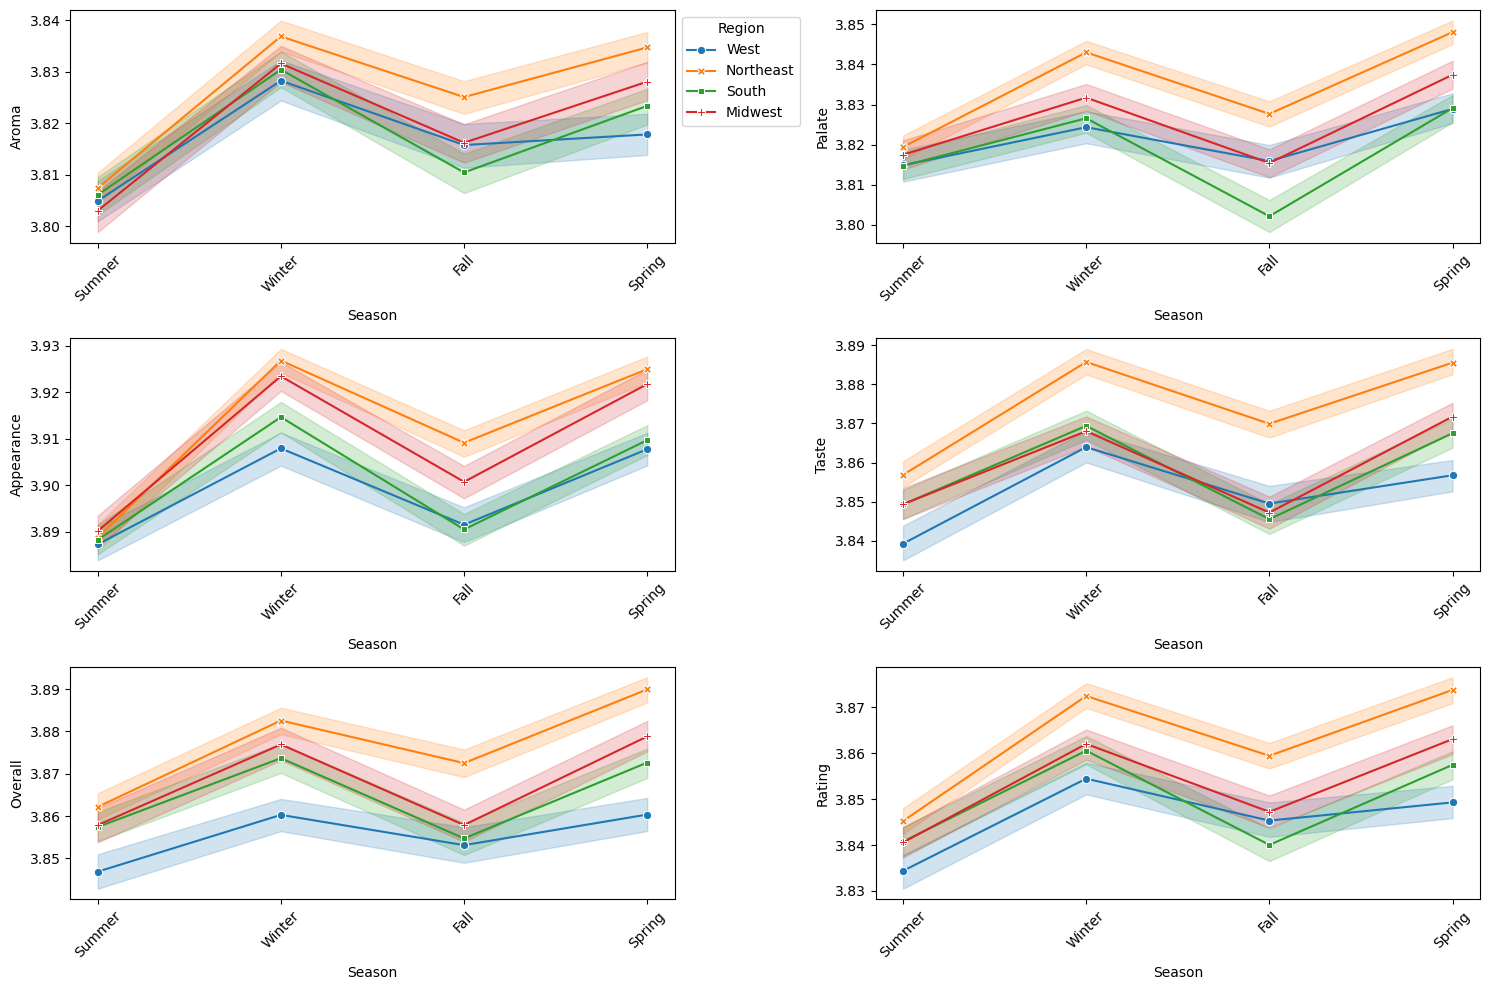

In [47]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']


plt.figure(figsize=(15, 10))

for j, rating in enumerate(rating_columns):
    
    plt_index = j + 1  
    plt.subplot(3, 2, plt_index) 

    sns.lineplot(data=reviews, x='season', y=rating, hue='region', style='region', markers=True, dashes=False)

    plt.xlabel('Season')
    plt.ylabel(f'{rating.capitalize()}')
    plt.xticks(rotation=45)

    # Only display the legend in the top-left subplot (plt_index == 1)
    if plt_index == 1:
        plt.legend(title='Region', loc='upper left', bbox_to_anchor=(1, 1))
    else:
        plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We observe a similar trend across all rating categories (aroma, palate, taste, appearance, overall, and rating). Therefore, we can continue the analysis by focusing on the ‘rating’ variable, which serves as a composite score derived from the other five ratings.

Northeast gives higher ratings across all season.

In [48]:
from scripts.script import seasonal_region_test

In [49]:
anova_results= seasonal_region_test(reviews, rating_column='rating') 

Season: Summer, Rating Column: rating
ANOVA p-value: 0.0001 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast   0.0047 0.1547 -0.0011  0.0104  False
  Midwest     South   0.0002 0.9998 -0.0058  0.0062  False
  Midwest      West  -0.0062 0.0604 -0.0126  0.0002  False
Northeast     South  -0.0045 0.1729 -0.0101  0.0012  False
Northeast      West  -0.0109    0.0 -0.0169 -0.0048   True
    South      West  -0.0064 0.0459 -0.0127 -0.0001   True
----------------------------------------------------------
--------------------------------------------------
Season: Winter, Rating Column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
---------------------------------------

Northeast and West show frequent significant differences across seasons

#### Comparaison by states and alcohol content

First, we need to ensure that the number of ratings is relatively consistent across each category:

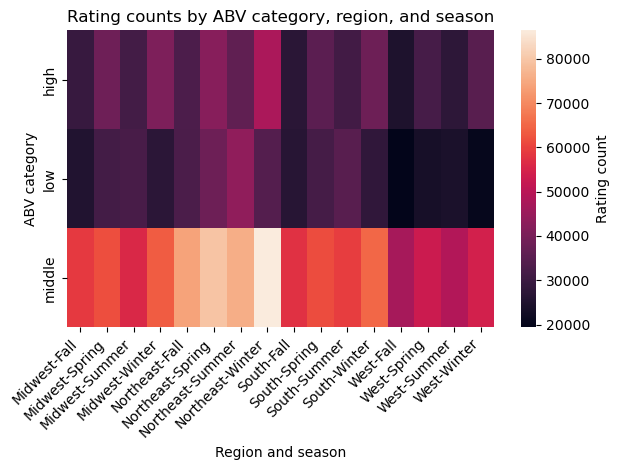

In [50]:
ratings_count = reviews.groupby(['abv_category', 'region', 'season'])['overall'].count().reset_index()
ratings_count = ratings_count.rename(columns={'overall': 'rating_count'})

pivot_table = ratings_count.pivot_table(
    index='abv_category', columns=['region', 'season'], values='rating_count', fill_value=0
)

sns.heatmap(pivot_table, cbar_kws={'label': 'Rating count'})
plt.title("Rating counts by ABV category, region, and season")
plt.xlabel("Region and season")
plt.ylabel("ABV category")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

The middle abv category has the highest rating count, this is expected as we used 25-50% quantile and the other abv category only 25% of the total number of ratings. There are however more ratings for the Northeast users during winter.  

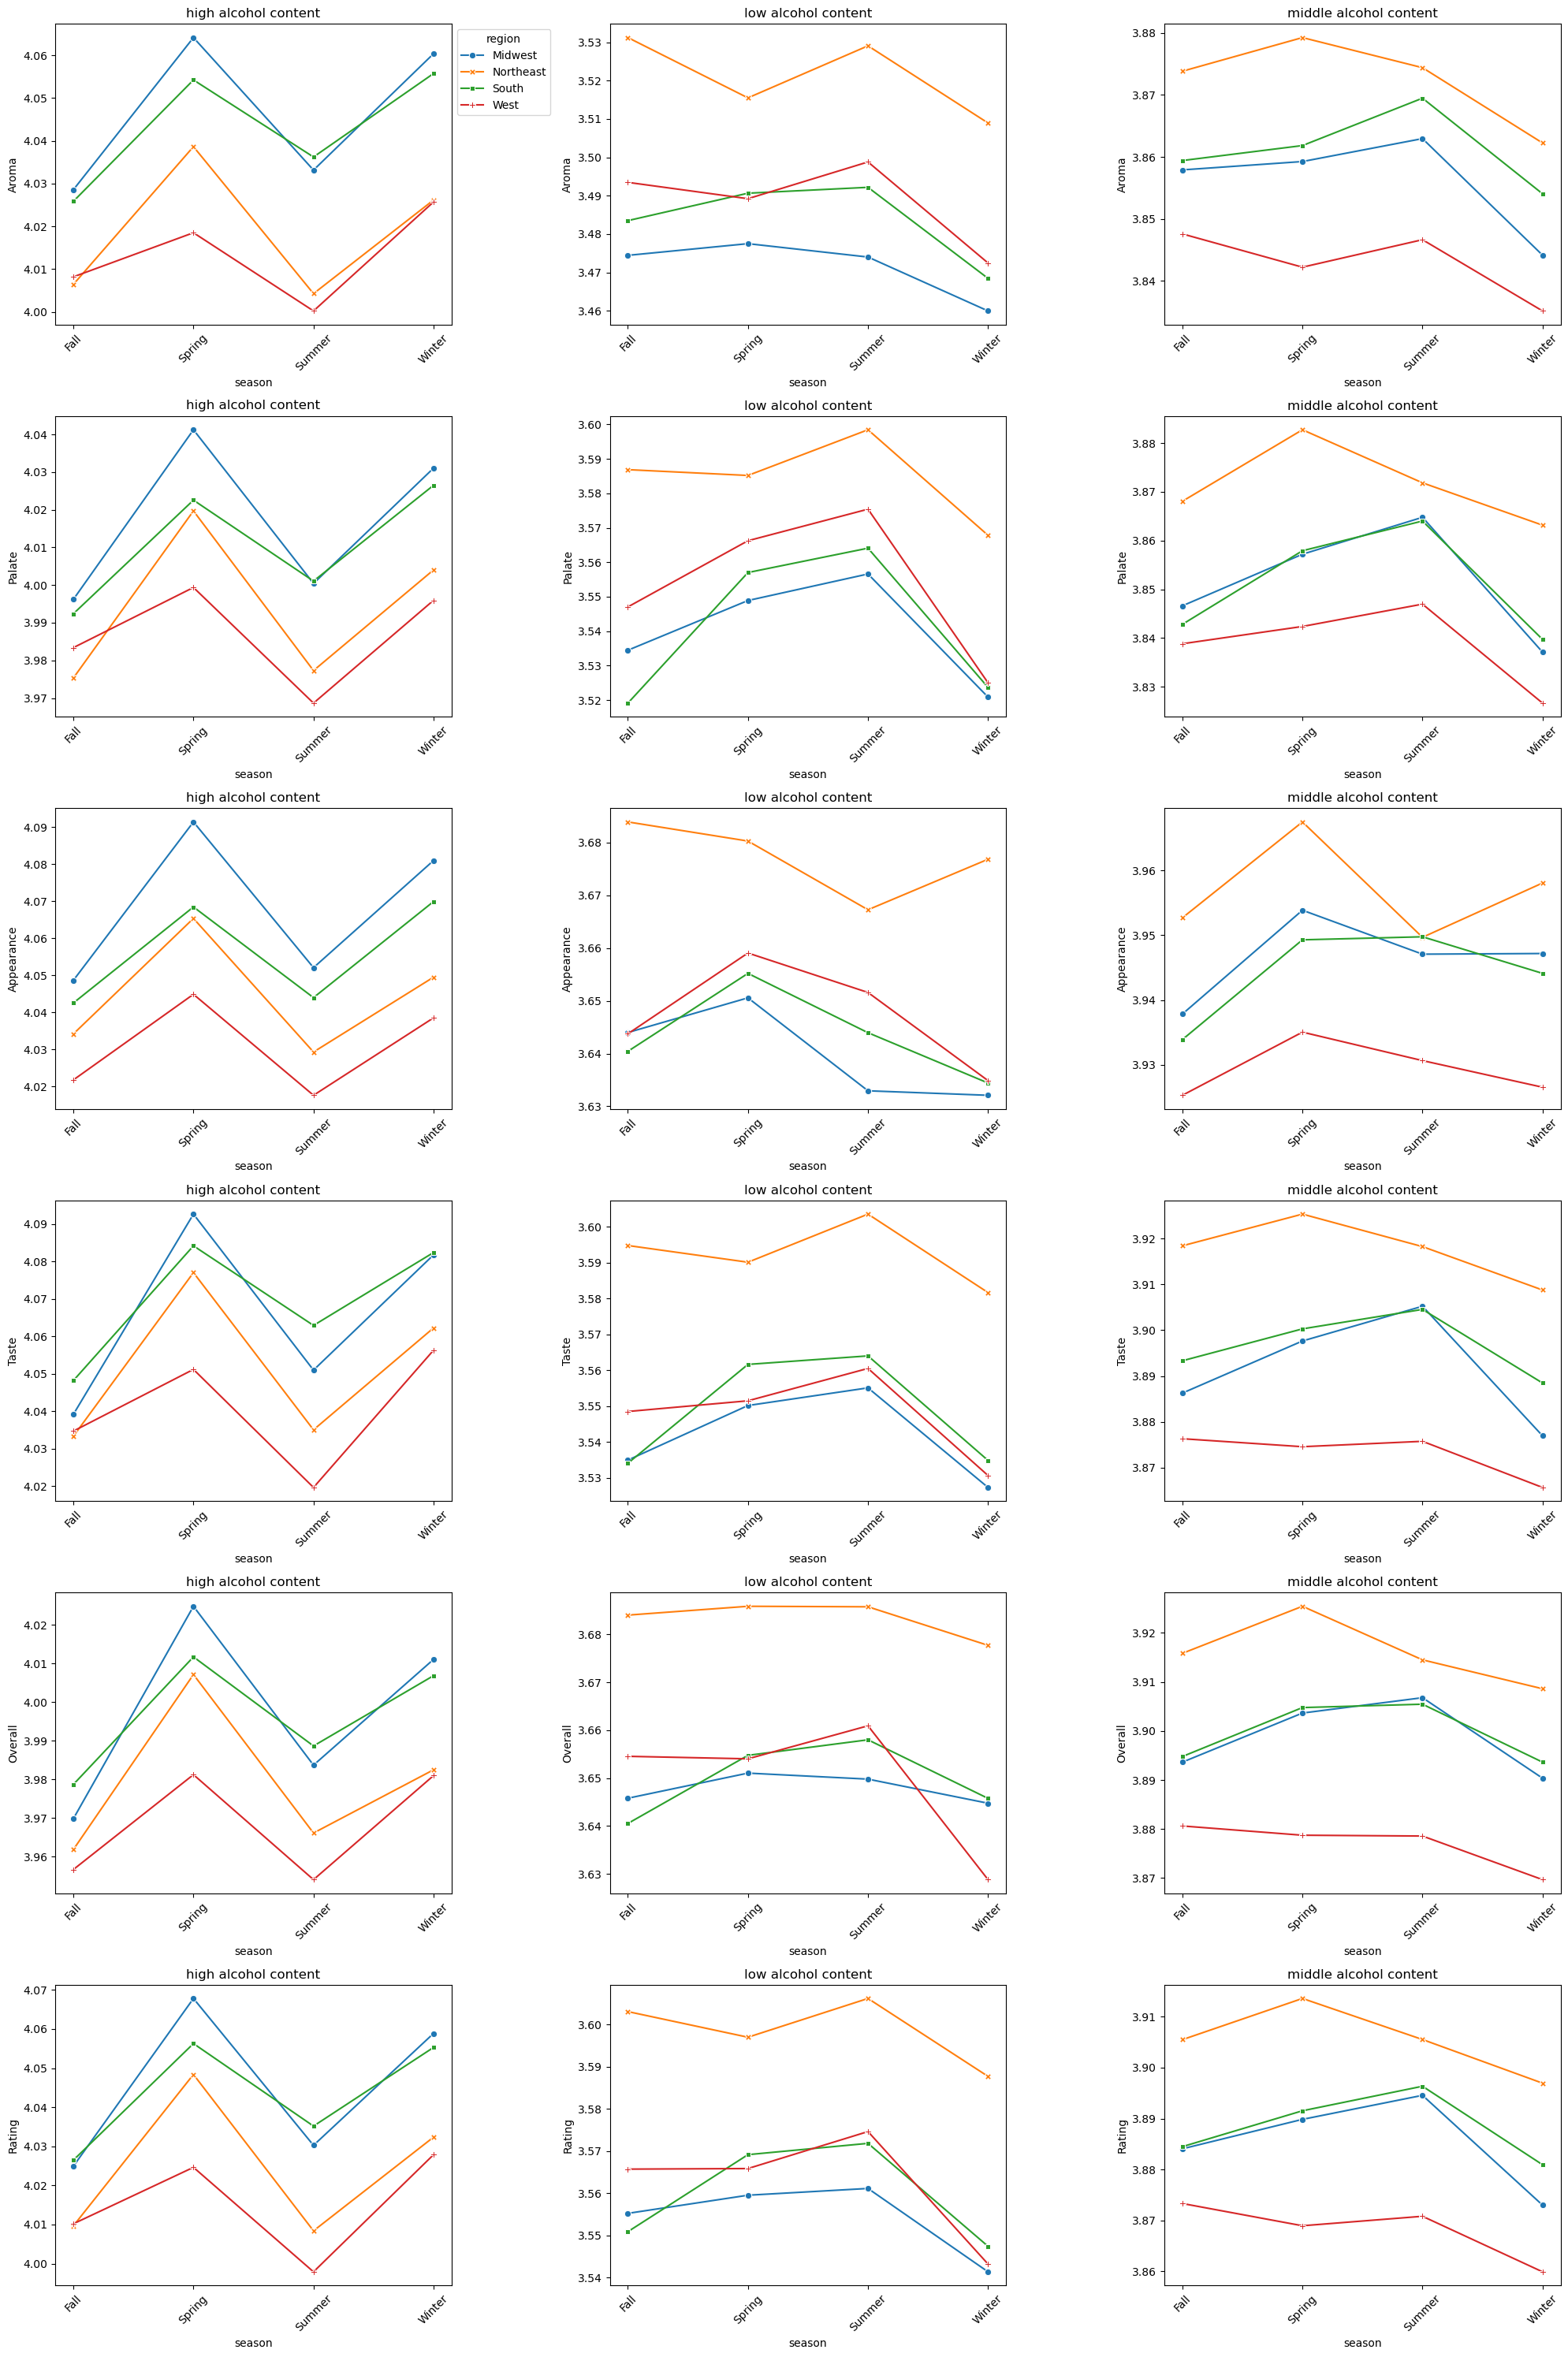

In [51]:
rating_columns = ['aroma', 'palate', 'appearance', 'taste', 'overall', 'rating']
grouped_reviews = reviews.groupby(['season', 'region', 'abv_category'])[rating_columns].mean().reset_index()

# All ABV categories
abvs = grouped_reviews['abv_category'].unique()

plt.figure(figsize=(20, 30))


for j, rating in enumerate(rating_columns):
    for i, abv in enumerate(abvs):
        
        # Calculate the plot index for the grid
        plt_index = j * len(abvs) + i + 1
        plt.subplot(6, 3, plt_index)
        
        # Filter data for the ABV category
        abv_data = grouped_reviews[grouped_reviews['abv_category'] == abv]
        
        sns.lineplot(data=abv_data, x='season', y=rating, hue='region', style='region', markers=True, dashes=False)
        
        plt.title(f'{abv} alcohol content')
        plt.xlabel('season')
        plt.ylabel(f'{rating.capitalize()}')
        plt.xticks(rotation=45)
        
        # Only display legend in the top-left subplot
        if plt_index == 1:
            plt.legend(title='region', loc='upper left', bbox_to_anchor=(1, 1))
        else:
            plt.legend([], [], frameon=False)

plt.tight_layout()
plt.show()

We observe a similar trend across all rating categories (aroma, palate, taste, appearance, overall, and rating). Therefore, we can continue the analysis by focusing on the ‘rating’ variable, which serves as a composite score derived from the other five ratings.

**statistical analysis:**

In [52]:
from scripts.script import seasonal_region_abv_test

In [53]:
anova_results_low = seasonal_region_abv_test(reviews, abv_category='low', rating_column='rating')

season: Summer, ABV category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast   0.0451    0.0  0.0331   0.057   True
  Midwest     South   0.0107 0.1291 -0.0019  0.0233  False
  Midwest      West   0.0135 0.0601 -0.0004  0.0274  False
Northeast     South  -0.0344    0.0 -0.0461 -0.0227   True
Northeast      West  -0.0316    0.0 -0.0446 -0.0185   True
    South      West   0.0028 0.9526 -0.0108  0.0164  False
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: low, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
-


**Low** alcohol content: For all season, the Midwest has higher ratings than the Northeast, while the South and West showed no significant differences.


In [54]:
anova_results_high = seasonal_region_abv_test(reviews, abv_category='high', rating_column='rating')

season: Summer, ABV category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast  -0.0219    0.0 -0.0325 -0.0113   True
  Midwest     South   0.0049 0.6592 -0.0061  0.0159  False
  Midwest      West  -0.0323    0.0 -0.0437  -0.021   True
Northeast     South   0.0268    0.0  0.0162  0.0374   True
Northeast      West  -0.0105  0.068 -0.0215  0.0005  False
    South      West  -0.0373    0.0 -0.0486 -0.0259   True
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: high, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject

**High** alcohol content:
- Summer: Midwest and Northeast, and South and West showed significant differences, with the Midwest rating lower than the Northeast and the West.
- Winter: Similar trends, with the Midwest rated lower than the Northeast and West
- Fall: Significant differences between the Midwest and Northeast, and Midwest and West
- Spring: All regions were significantly different, with the Midwest showing lower ratings compared to the Northeast and West.

In [55]:
anova_results_middle = seasonal_region_abv_test(reviews, abv_category='middle', rating_column='rating')

season: Summer, ABV category: middle, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  reject
----------------------------------------------------------
  Midwest Northeast    0.011 0.0008  0.0036  0.0184   True
  Midwest     South   0.0018 0.9363  -0.006  0.0096  False
  Midwest      West  -0.0237    0.0  -0.032 -0.0155   True
Northeast     South  -0.0092 0.0066 -0.0165 -0.0019   True
Northeast      West  -0.0347    0.0 -0.0424  -0.027   True
    South      West  -0.0255    0.0 -0.0336 -0.0174   True
----------------------------------------------------------
--------------------------------------------------
season: Winter, ABV category: middle, rating column: rating
ANOVA p-value: 0.0000 - Significant difference between regions
   Multiple Comparison of Means - Tukey HSD, FWER=0.05    
  group1    group2  meandiff p-adj   lower   upper  re

**High** alcohol content: All are statistically different except Midwest vs south for summer,spring and fall


In conclusion, the ratings made by users in different regions (South, Midwest, Northeast, and West) are statistically significant. 

#### Comparaison by states and alcohol content

In [56]:
reviews.head()

,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,user_name,location,country,states,region,abv_category,year,month,day,season
0,4.5,3.25,2.75,142544,Régab,37262,Societe des Brasseries du Gabon (SOBRAGA),2015-08-20 10:00:00,3.00,3.25,...,nmann08,"United States, Washington",United States,Washington,West,low,2015,8,20,Summer
1,4.5,3.00,3.50,19590,Barelegs Brew,10093,Strangford Lough Brewing Company Ltd,2009-02-20 11:00:00,3.50,3.50,...,StJamesGate,"United States, New York",United States,New York,Northeast,low,2009,2,20,Winter
2,4.8,4.25,4.50,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-02-13 11:00:00,3.75,3.25,...,brewdude1982,"United States, North Carolina",United States,North Carolina,South,low,2013,2,13,Winter
3,4.8,4.00,3.75,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2013-01-09 11:00:00,3.75,3.50,...,AgentMunky,"United States, New York",United States,New York,Northeast,low,2013,1,9,Winter
4,4.8,3.00,3.50,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2012-11-17 11:00:00,2.50,2.50,...,ferrari29,"United States, Illinois",United States,Illinois,Midwest,low,2012,11,17,Fall


In [57]:
best_rated = reviews.groupby(['season', 'region', 'style'])['rating'].mean().reset_index()

# Sort the values by rating in descending order
best_rated = best_rated.sort_values(by=['season', 'region', 'rating'], ascending=[True, True, False])

# Get top 3 beer styles for each region and season
top_3 = best_rated.groupby(['season', 'region']).head(3).reset_index(drop=True)

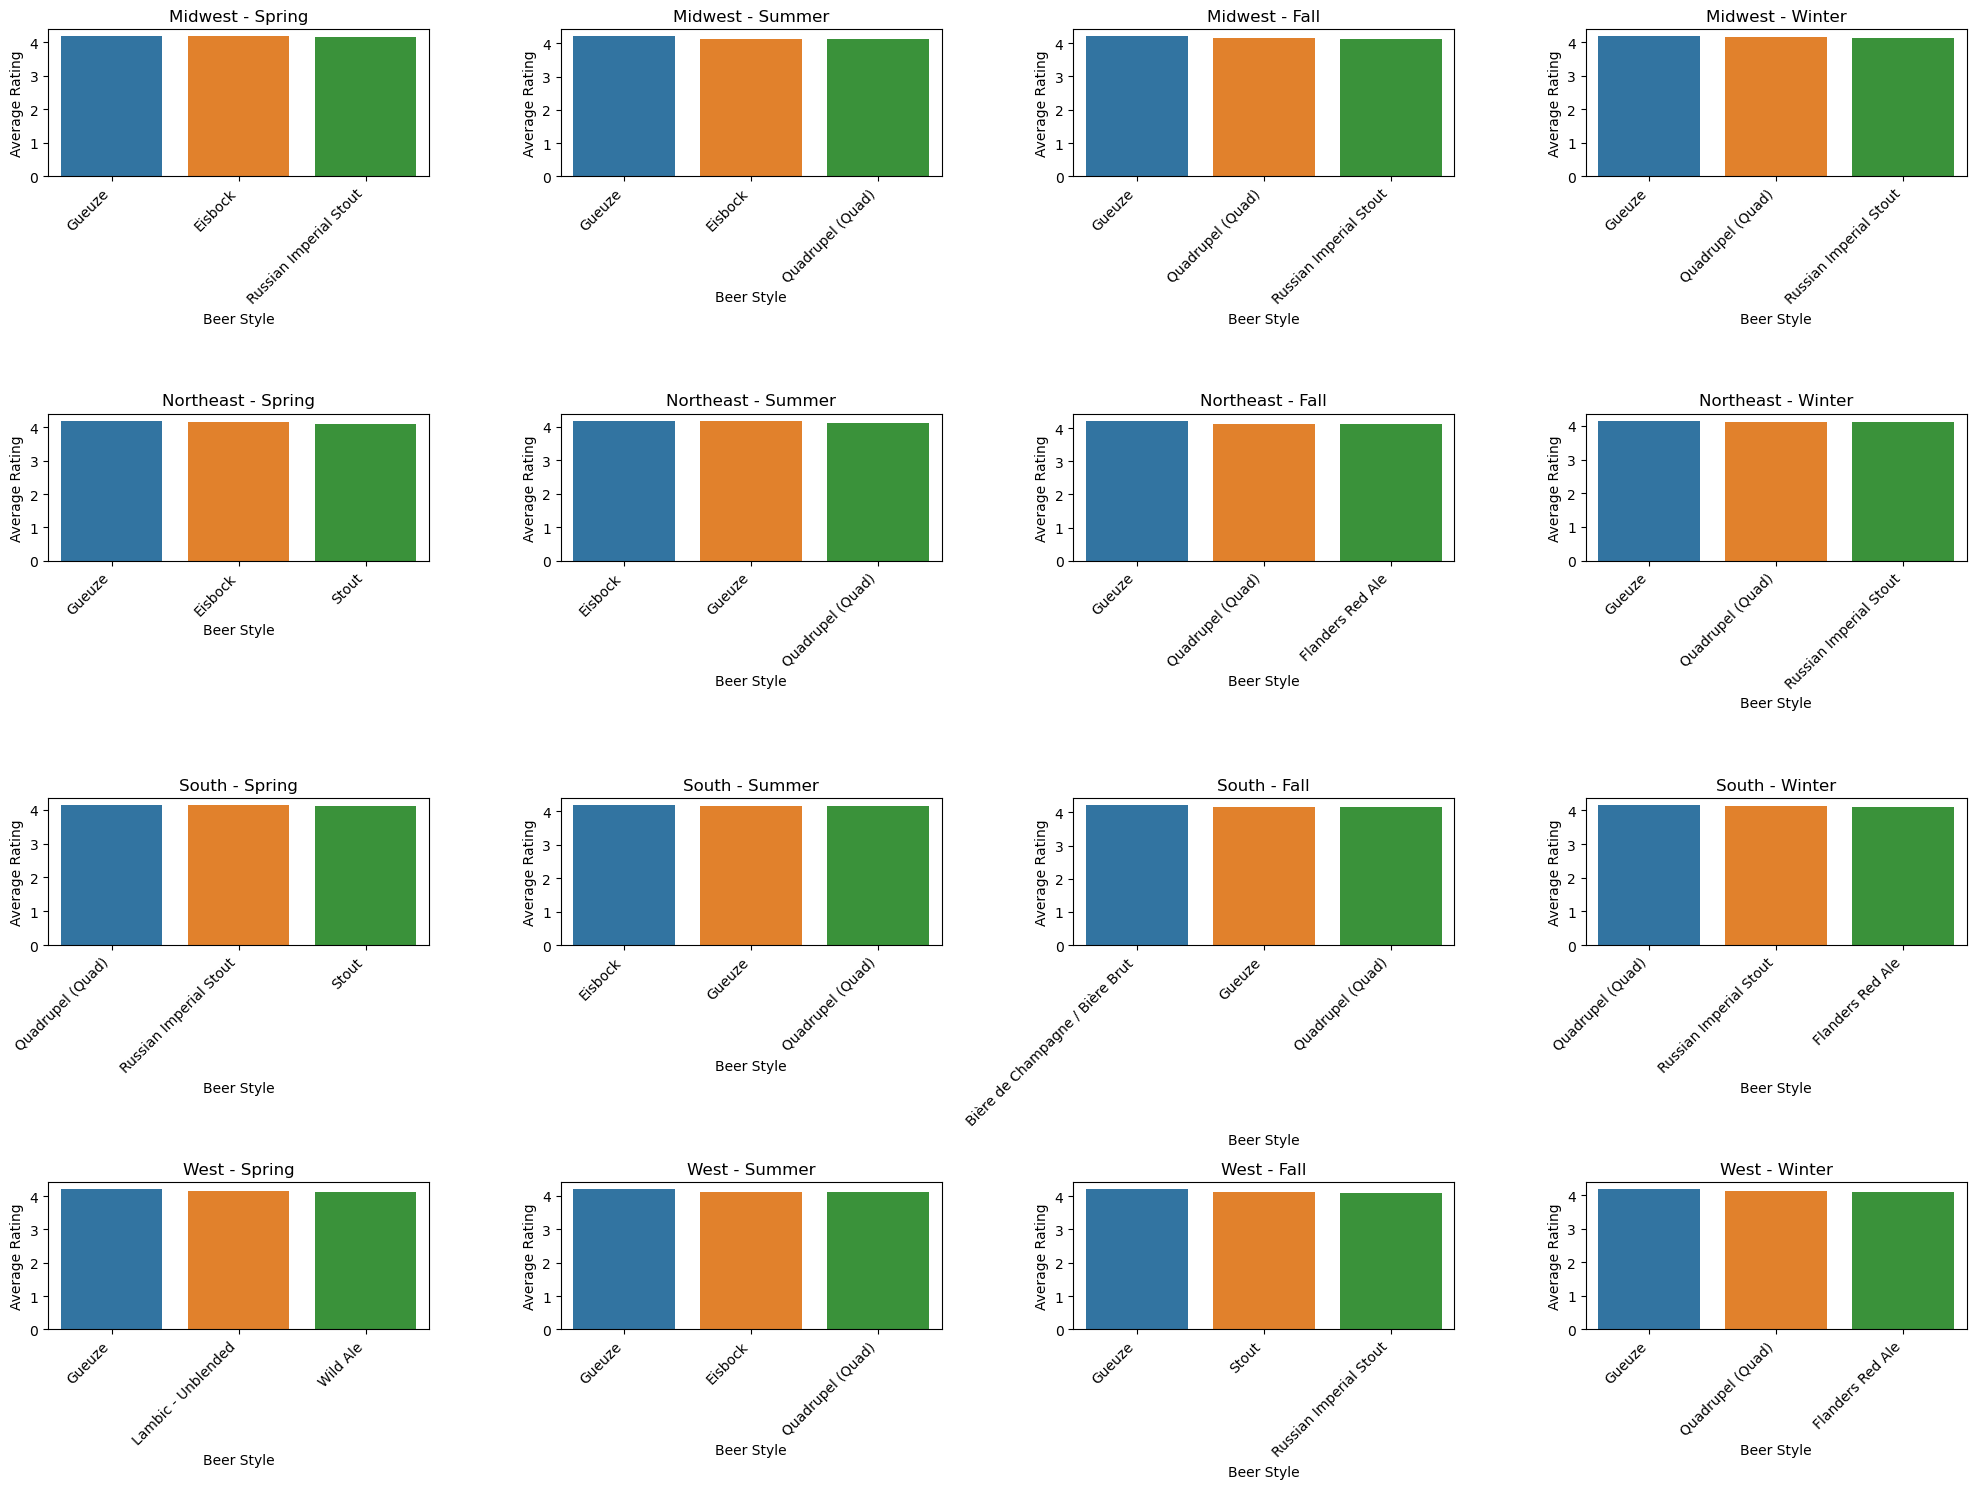

In [58]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
axes = axes.flatten()

regions = top_3['region'].unique()
seasons = ['Spring', 'Summer', 'Fall', 'Winter']

for i, region in enumerate(regions):
    for j, season in enumerate(seasons):
        ax = axes[i * 4 + j]
        
        # Filter data for the specific region and season
        data = top_3[(top_3['region'] == region) & (top_3['season'] == season)]
        
        # Create the bar plot for the top 3 beer styles
        sns.barplot(x='style', y='rating', data=data, ax=ax, hue='style', legend=False)
        
        # Set title and labels
        ax.set_title(f'{region} - {season}', fontsize=12)
        ax.set_xlabel('Beer Style', fontsize=10)
        ax.set_ylabel('Average Rating', fontsize=10)
        ax.set_xticks(range(len(data['style']))) 
        ax.set_xticklabels(data['style'], rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()

The beer style the highest rated is not always the same across season and region. For example the Gueuze is not in the top 3 for the south user in winter or the Bière de Champagne is only in the top 3 of the south user in fall. 

## Sentiment analysis